Click this button to run in Colab.
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ssuai/deep_learning_from_scratch_2/blob/master/ch06/1_lstm.ipynb)

In [5]:
# some helper functions for Colab
def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

if is_colab():
    !git clone --filter=blob:none --sparse https://github.com/ssuai/deep_learning_from_scratch_2.git
    %cd deep_learning_from_scratch_2
    !git sparse-checkout set dataset common ch06
else:
    import sys
    import os
#     sys.path.append('..')
    sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정

Cloning into 'deep_learning_from_scratch_2'...
remote: Enumerating objects: 437, done.
remote: Counting objects: 100% (222/222), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 437 (delta 189), reused 185 (delta 169), pack-reused 215 (from 2)
Receiving objects: 100% (437/437), 76.37 KiB | 5.87 MiB/s, done.
Resolving deltas: 100% (242/242), done.
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 5 (delta 0), reused 0 (delta 0), pack-reused 4 (from 2)
Receiving objects: 100% (5/5), 22.11 MiB | 34.99 MiB/s, done.
Updating files: 100% (5/5), done.
/content/deep_learning_from_scratch_2/deep_learning_from_scratch_2
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 28 (delta 3), reused 3 (delta 1), pack-reused 8 (from 2)
Receiving objects: 100% (28/28), 4.79 MiB | 22.42 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [6]:
# %load rnnlm.py
# import sys
# sys.path.append('..')
from common.time_layers import *
from common.base_model import BaseModel


class Rnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]

        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.lstm_layer.reset_state()


| 에폭 1 |  반복 1 / 1327 | 시간 0[s] | 퍼플렉서티 10000.25
| 에폭 1 |  반복 21 / 1327 | 시간 5[s] | 퍼플렉서티 2673.20
| 에폭 1 |  반복 41 / 1327 | 시간 13[s] | 퍼플렉서티 1245.42
| 에폭 1 |  반복 61 / 1327 | 시간 19[s] | 퍼플렉서티 965.10
| 에폭 1 |  반복 81 / 1327 | 시간 24[s] | 퍼플렉서티 802.81
| 에폭 1 |  반복 101 / 1327 | 시간 31[s] | 퍼플렉서티 652.74
| 에폭 1 |  반복 121 / 1327 | 시간 37[s] | 퍼플렉서티 628.18
| 에폭 1 |  반복 141 / 1327 | 시간 44[s] | 퍼플렉서티 588.21
| 에폭 1 |  반복 161 / 1327 | 시간 50[s] | 퍼플렉서티 550.90
| 에폭 1 |  반복 181 / 1327 | 시간 57[s] | 퍼플렉서티 563.94
| 에폭 1 |  반복 201 / 1327 | 시간 63[s] | 퍼플렉서티 480.15
| 에폭 1 |  반복 221 / 1327 | 시간 71[s] | 퍼플렉서티 482.40
| 에폭 1 |  반복 241 / 1327 | 시간 77[s] | 퍼플렉서티 433.79
| 에폭 1 |  반복 261 / 1327 | 시간 84[s] | 퍼플렉서티 454.17
| 에폭 1 |  반복 281 / 1327 | 시간 90[s] | 퍼플렉서티 444.95
| 에폭 1 |  반복 301 / 1327 | 시간 97[s] | 퍼플렉서티 380.29
| 에폭 1 |  반복 321 / 1327 | 시간 103[s] | 퍼플렉서티 338.25
| 에폭 1 |  반복 341 / 1327 | 시간 110[s] | 퍼플렉서티 393.38
| 에폭 1 |  반복 361 / 1327 | 시간 115[s] | 퍼플렉서티 397.93
| 에폭 1 |  반복 381 / 1327 | 시간 123[s] | 퍼플렉서티 322.22


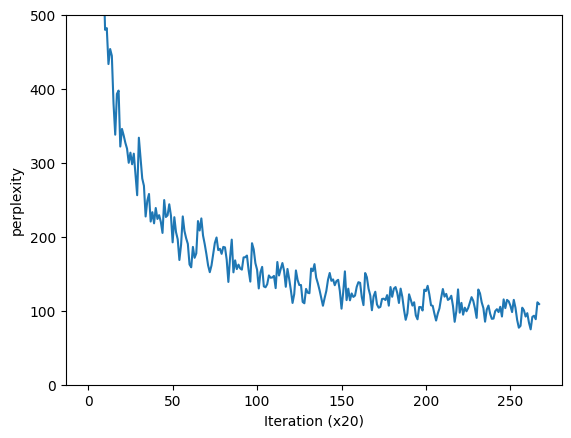

In [7]:
# %load train_rnnlm.py
# import sys
# sys.path.append('..')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb
# from rnnlm import Rnnlm  # defined above


# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
time_size = 35     # RNN을 펼치는 크기
lr = 20.0
max_epoch = 4
max_grad = 0.25

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# 모델 생성
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# 기울기 클리핑을 적용하여 학습
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad,
            eval_interval=20)
trainer.plot(ylim=(0, 500))

In [8]:
# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

# 매개변수 저장
model.save_params()

퍼플렉서티 평가 중 ...
234 / 235
테스트 퍼플렉서티:  137.05073659822423
